In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves')

In [2]:
from help_funcs import * 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import gsw

import pandas as pd
import xarray as xr
import numpy as np
import netCDF4 as nc

import cmocean.cm as cm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

from multiprocessing import Pool
import multiprocessing
from os.path import exists
from pathlib import Path
from natsort import natsorted
import importlib

In [3]:
sns.set_context("notebook")

In [4]:
%%time
GLORYS_dir = r"/vortexfs1/home/anthony.meza/GLORYS_data" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 173 ms, sys: 20 ms, total: 193 ms
Wall time: 970 ms


In [5]:
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")
def sigma0_from_SP_and_pt0(z, SP, pt0, lon = 0, lat = 30):
    p = gsw.p_from_z(-np.abs(z), lat)
    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_pt(SA,pt0)
    sigma0 = gsw.sigma0(SA,CT)
    return sigma0

def sigma0_on_xarray(ds):
    z = -ds.depth
    SP = ds.so
    pt0 = ds.thetao
    sigma0_ds = np.nan*ds.thetao.rename("sigma0")
    sigma0_ds.values = sigma0_from_SP_and_pt0(z, SP, pt0)

    return sigma0_ds

def timecat(fnames):
    datasets = xr.concat(fnames, dim = "time", data_vars = "minimal", coords = "minimal")
    datasets = datasets.sortby("time")
    return datasets

def read_GLORYS_subset(years, read_ocn):
    n_cores = multiprocessing.cpu_count() - 5
    dsets = []
    for year in years:
        print(year)
        files = np.empty(0, dtype = str)
        for month in months:
            file_path = GLORYS_dir + "/" + year + "/" + month
            file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
            files = np.concatenate([files, file_list])
        files = natsorted([str(f) for f in files])
        if __name__ == '__main__':
            with Pool(n_cores) as p:
                datasets = p.map(read_ocn, files)
        datasets = [d for d in datasets]
        dsets = dsets + datasets #about 50 gigs of data!! 
    
    return dsets

In [6]:
def plot_spatial_var(ax, data, LONS, LATS, bounds, levels):
    cf = ax.contourf(LONS, LATS, data, 
                      vmin = -bounds, vmax = bounds, levels = levels, 
                      cmap=cm.curl, extend = "both")
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
    return cf 

def animate_spatial_var(da, NINO_idx, event_name):


    
    data = da.values
    times = da.time.values
    times = pd.to_datetime(times).strftime('%Y-%m-%d')
    nt = len(times)

    # fig,ax1 = plt.subplots(figsize = (5, 5),  subplot_kw = {"projection":ccrs.PlateCarree()})
    fig = plt.figure(figsize = (5, 5))
    
    gs = fig.add_gridspec(3, 6)
    ax1 = fig.add_subplot(gs[:, 0:2], projection=ccrs.PlateCarree())

    ax2 = fig.add_subplot(gs[:, 2:])
    ax2.plot(times, NINO_idx)
    ax2.scatter(times[0], NINO_idx[0], c = "red")
    
    LONS, LATS = np.meshgrid(da.longitude, da.latitude)
    bounds = np.nanmax(np.abs(data))
    levels = np.linspace(-bounds, bounds, 21)

    cf = plot_spatial_var(ax1, data[0, :, :], LONS, LATS, bounds, levels)

    fig.colorbar(cf, fraction = 0.03, ax = ax1, orientation = "vertical")
    fig.suptitle("Potential Density Anomalies \n (Seasonal Cycle Removed)")
    fig.tight_layout()
    fig 
    
#     def animate(i):
#         ax1.clear(); 
#         fontweight = "normal" if NINO_idx.values[i] < 0.5 else "bold"
#         ax1.set_title(times[i] + "; NIÑO 3.4 = " + str(NINO_idx.values[i]), fontweight = fontweight)
#         plot_spatial_var(ax1, data[i, :, :], LONS, LATS, bounds, levels)
#         ax2.clear(); 
#         ax2.plot(times, NINO_idx)
#         ax2.scatter(times[i], NINO_idx.values[i], c = "red")

#     anim = FuncAnimation(fig, animate, frames=100, interval=100, blit=False)
#     anim.save(event_name + '.gif', writer='ffmpeg')

### Get NINO 3.4 Index

In [7]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1993", None))

### Make some anomaly movies 

In [8]:
def read_ds_ocn(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]].sel(depth = 77, method = "nearest")
        ds_new = ds_new.sel(longitude = slice(-124, -114), latitude = slice(25, 40) )
        return ds_new

In [9]:
GLORYS_ds_clim = read_ds_ocn("GLORYS_processed/GLORYS_Data.nc")
GLORYS_ds_clim = GLORYS_ds_clim.isel(time = slice(0,312)) #data corrupted beyond 312
sigma0_climatology =  sigma0_on_xarray(GLORYS_ds_clim)
sigma0_climatology = sigma0_climatology.groupby("time.month").mean("time")

In [21]:
%%time 
all_years = [["1997", "1998", "1999"], ["2001", "2002", "2003"],
             ["2005", "2006", "2007"], ["2008", "2009", "2010"],
             ["2014", "2015", "2016"]]

all_slices = [slice("1997", "1999.4"), slice("2001.5", "2003"),
              slice("2005.5", "2007"), slice("2008.7", "2010"),
              slice("2014", "2016")]

all_events = ["97Nino", "02Nino", 
              "06Nino", "09Nino", 
              "15Nino"]
nevents = len(all_events)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11 µs


In [22]:
def animate_years(yrs, time_slice, event_name):
    NINO = read_GLORYS_subset(yrs, read_ds_ocn)
    NINO_ds = timecat(NINO)

    sigma0_NINO =  sigma0_on_xarray(NINO_ds)

    #compute monthly anomalies 
    anomalies = sigma0_NINO.groupby("time.month") - sigma0_climatology
    sigma0_NINO_anom = anomalies.drop("month") 
    sigma0_NINO_anom = sigma0_NINO_anom.sel(time = time_slice)

    #get 
    NINO34_sub = remove_seasonal(NINO34).interp(time = sigma0_NINO_anom.time)
    NINO34_sub = np.round(NINO34_sub, decimals = 2).sel(time = time_slice)

    #animate
    animate_spatial_var(sigma0_NINO_anom, NINO34_sub, event_name)

97Nino
1997
1998
1999


/tmp/ipykernel_429008/331812547.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


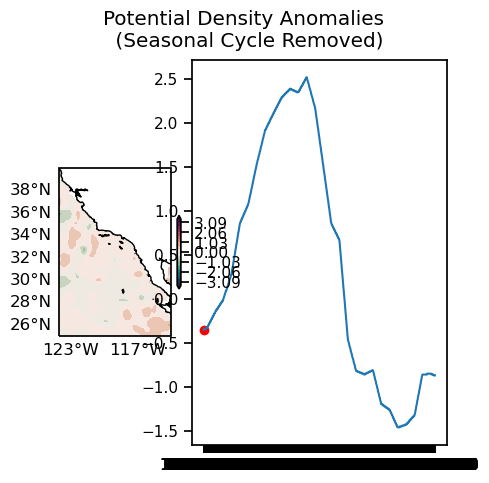

In [23]:
i = 0
yrs = all_years[i]; time_slice=all_slices[i]; event_name = all_events[i]
print(event_name)
#read in years
animate_years(yrs, time_slice, event_name + "test")

In [24]:
print("hi")

hi


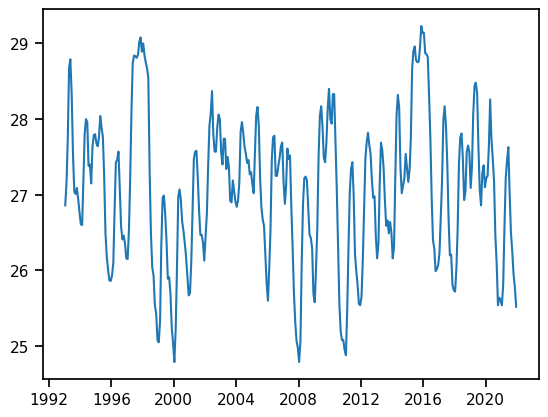

In [16]:
plt.plot(NINO34.time, NINO34.values)